### Middleware

Middleware provides a way to more tightly control what happens inside the agent. Middleware is useful for the following:
- Tracking agent behavior with logging, analytics, and debugging.
- Transforming prompts, tool selection, and output formatting.
- Adding retries, fallbacks, and early termination logic.
- Applying rate limits, guardrails, and PII detection.

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

### Summarization MiddleWare
Automatically summarize conversation history when approaching token limits, preserving recent messages while compressing older context. Summarization is useful for the following:
- Long-running conversations that exceed context windows.
- Multi-turn dialogues with extensive history.
- Applications where preserving full conversation context matters.

In [7]:
from langchain.chat_models import init_chat_model

model = init_chat_model("groq:openai/gpt-oss-20b")
model.profile

{'max_input_tokens': 131072,
 'max_output_tokens': 32768,
 'image_inputs': False,
 'audio_inputs': False,
 'video_inputs': False,
 'image_outputs': False,
 'audio_outputs': False,
 'video_outputs': False,
 'reasoning_output': True,
 'tool_calling': True}

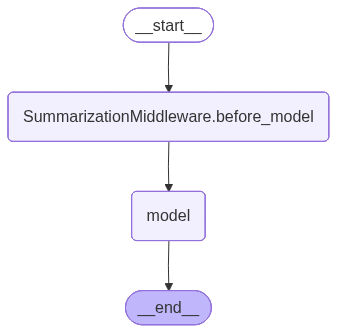

In [9]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, SystemMessage

agent = create_agent(
    model="groq:openai/gpt-oss-20b",
    tools = [],
    checkpointer = InMemorySaver(),
    middleware = [
        SummarizationMiddleware(
            model="groq:openai/gpt-oss-20b",
            trigger=("messages",10),
            keep=("messages",4)
        )
    ]
)

agent

In [10]:
# Run with thread id
config = {"configurable" : {"thread_id" : "test1"}}

In [11]:
questions = [
    "What is 10 + 45?",
    "What is 5 times 10?",
    "What is 65 times 22?",
    "What is 4598 divided by 64?",
    "What is 98 times 12?",
    "What is 12 times 12?",
    "What is 45678 + 65464",
]

In [12]:
for q in questions:
    response = agent.invoke({"messages" : [HumanMessage(content=q)]}, config=config)
    print(f"Messages : {response["messages"]}")
    print(f"Messages : {len(response["messages"])}")    

Messages : [HumanMessage(content='What is 10 + 45?', additional_kwargs={}, response_metadata={}, id='b68eda93-ebd1-44c3-84fc-51f1061f941d'), AIMessage(content='10 + 45 equals **55**.', additional_kwargs={'reasoning_content': 'The user asks: "What is 10 + 45?" They want the sum. That\'s 55. Just answer.'}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 79, 'total_tokens': 123, 'completion_time': 0.046594724, 'completion_tokens_details': {'reasoning_tokens': 26}, 'prompt_time': 0.003863981, 'prompt_tokens_details': None, 'queue_time': 0.052388668, 'total_time': 0.050458705}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bdc40-3f8a-7d93-9687-51157f8c7fac-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 79, 'output_tokens': 44, 'total_tokens': 123, 'output_token_details': {'reasoning': 26}})]
Me

### Token Size

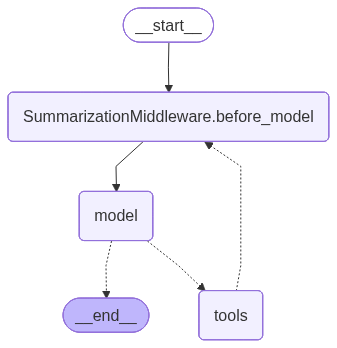

In [13]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langchain.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.tools import tool

@tool
def search_hotels(city: str)->str:
    """Search Hotels - returns long responses to use more tokens"""
    return f"""
    Hotels in {city}:
    1. The Leela - 5 star, 20,000/night, spa, pool, gym
    2. The Oberoi - 5 star, 45,000/night, pool, restaurants, gym
    3. Roseate - 5 star, 9,000/night, pool, spa, gym, restaurants
    """

agent = create_agent(
    model="groq:openai/gpt-oss-20b",
    tools = [search_hotels],
    checkpointer = InMemorySaver(),
    middleware = [
        SummarizationMiddleware(
            model = "groq:openai/gpt-oss-20b",
            trigger = ("tokens",550),
            keep = ("tokens",200)
        )
    ]
)

agent

In [14]:
config = {"configurable" : {"thread_id" : "test_2"}}

In [15]:
def count_tokens(messages):
    total_chars = sum(len(str(m.content)) for m in messages)
    return total_chars // 4 # 4 chars = 1 token

In [16]:
cities = ["New Delhi", "Jaipur", "Udaipur", "Goa", "Manali"]

for city in cities:
    response = agent.invoke(
        {"messages" : [HumanMessage(content=f"Find hotels in {city}")]},
        config = config
    )

    tokens = count_tokens(response["messages"])
    print(f"{city}: ~ {tokens} tokens, {len(response["messages"])} messages")
    print(f"{(response["messages"])}")

New Delhi: ~ 228 tokens, 4 messages
[HumanMessage(content='Find hotels in New Delhi', additional_kwargs={}, response_metadata={}, id='3cc124c4-9cc8-4113-99df-8b94383db4e4'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call the search_hotels function with city "New Delhi".', 'tool_calls': [{'id': 'fc_add6bd31-ec59-4a42-afe6-85887d404a02', 'function': {'arguments': '{"city":"New Delhi"}', 'name': 'search_hotels'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 130, 'total_tokens': 171, 'completion_time': 0.042244622, 'completion_tokens_details': {'reasoning_tokens': 16}, 'prompt_time': 0.006386901, 'prompt_tokens_details': None, 'queue_time': 0.052935529, 'total_time': 0.048631523}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bdc40-9107-70a1-9c7d-0adb4af9ad0

### Fraction

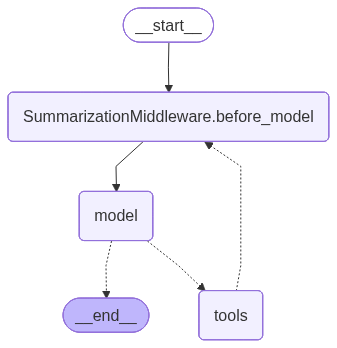

In [17]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langchain.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.tools import tool

@tool
def search_hotels(city: str)->str:
    """Search Hotels - returns long responses to use more tokens"""
    return f"""Hotels in {city}: Roseate - 5 star, 9,000/night, pool, spa, gym, restaurants"""

agent = create_agent(
    model="groq:openai/gpt-oss-20b",
    tools = [search_hotels],
    checkpointer = InMemorySaver(),
    middleware = [
        SummarizationMiddleware(
            model = "groq:openai/gpt-oss-20b",
            trigger = ("fraction",0.005), # 655 tokens approx
            keep = ("fraction",0.002) # 262 tokens approx
        )
    ]
)

agent

In [18]:
config = {"configurable" : {"thread_id" : "test_3"}}

In [19]:
def count_tokens(messages):
    total_chars = sum(len(str(m.content)) for m in messages)
    return total_chars // 4 # 4 chars = 1 token

In [20]:
cities = ["New Delhi", "Jaipur", "Udaipur", "Goa", "Manali"]

for city in cities:
    response = agent.invoke(
        {"messages" : [HumanMessage(content=f"Find hotel in {city}")]},
        config = config
    )

    tokens = count_tokens(response["messages"])
    fraction = tokens / 131072
    print(f"{city} : ~ {tokens} tokens ({fraction:.4f}), {len(response["messages"])} messages")
    print(response["messages"])

New Delhi : ~ 636 tokens (0.0049), 6 messages
[HumanMessage(content='Find hotel in New Delhi', additional_kwargs={}, response_metadata={}, id='f3577168-1da1-4488-a708-7ead467e1a36'), AIMessage(content='', additional_kwargs={'reasoning_content': 'The user: "Find hotel in New Delhi". They likely want a list of hotels. We can use the search_hotels function. We\'ll call it with city "New Delhi".', 'tool_calls': [{'id': 'fc_247edbdd-562e-4e10-bf96-4f62f811bff8', 'function': {'arguments': '{"city":"New Delhi"}', 'name': 'search_hotels'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 130, 'total_tokens': 192, 'completion_time': 0.064087708, 'completion_tokens_details': {'reasoning_tokens': 37}, 'prompt_time': 0.006616132, 'prompt_tokens_details': None, 'queue_time': 0.156023527, 'total_time': 0.07070384}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_75c733514d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', '

KeyboardInterrupt: 

### Human In the Loop MiddleWare

Pause agent execution for human approval, editing, or rejection of tool calls before they execute. Human-in-the-loop is useful for the following:
- High-stakes operations requiring human approval (e.g. database writes, financial transactions).
- Compliance workflows where human oversight is mandatory.
- Long-running conversations where human feedback guides the agent.

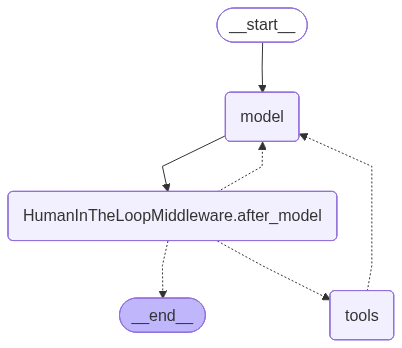

In [1]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langchain_core.tools import tool
from langchain.messages import HumanMessage

@tool
def read_email_tool(email_id: str)->str:
    """Mock Function to read an email by its ID"""
    return f"Email content for ID : {email_id}"

@tool
def send_email_tool(recipient: str, subject: str, body: str)->str:
    """Mock Function to send an email"""
    return f"Email sent to {recipient} with subject: {subject}"

agent = create_agent(
    model = "groq:openai/gpt-oss-120b",
    tools = [read_email_tool, send_email_tool],
    checkpointer = InMemorySaver(),
    middleware = [
        HumanInTheLoopMiddleware(
            interrupt_on = {
                "send_email_tool" : {
                    "allowed_decisions" : ["approve", "edit", "reject"]
                },
                "read_email_tool" : False,
            }
        )
    ]
)

agent

In [2]:
config = {"configurable" : {"thread_id" : "test_approve"}}

# Step 1 : Request
result = agent.invoke(
    {"messages" : [HumanMessage(content="Send email to johndoe@gmail.com with subject 'Hello' and body 'How are you?'")]},
    config = config
)

In [3]:
result

{'messages': [HumanMessage(content="Send email to johndoe@gmail.com with subject 'Hello' and body 'How are you?'", additional_kwargs={}, response_metadata={}, id='a6bca8b7-d57e-4b7d-9720-e774be97286f'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to send email using send_email_tool. Provide parameters.', 'tool_calls': [{'id': 'fc_cb039b62-0df3-459a-8f9b-478af1ae2830', 'function': {'arguments': '{"body":"How are you?","recipient":"johndoe@gmail.com","subject":"Hello"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 176, 'total_tokens': 239, 'completion_time': 0.145429947, 'completion_tokens_details': {'reasoning_tokens': 14}, 'prompt_time': 0.007645341, 'prompt_tokens_details': None, 'queue_time': 0.055766799, 'total_time': 0.153075288}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_626f3fc5e0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logpr

#### Approve

In [4]:
from langgraph.types import Command
# Step 2 : Approve
if "__interrupt__" in result:
    print("Paused, Approving!")

    result = agent.invoke(
        Command(
            resume = {
                "decisions" : [
                    {"type" : "approve"}
                ]
            }
        ),
        config = config
    )

    print(f"Result : {result["messages"][-1].content}")

Paused, Approving!
Result : The email has been sent successfully. Let me know if there’s anything else you need!


#### Reject

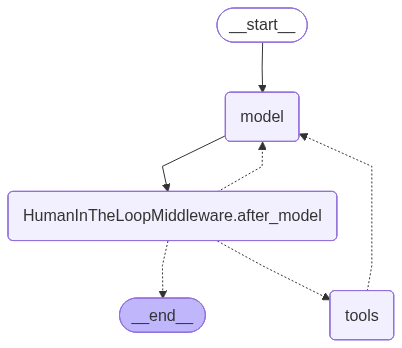

In [5]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langchain_core.tools import tool
from langchain.messages import HumanMessage

@tool
def read_email_tool(email_id: str)->str:
    """Mock Function to read an email by its ID"""
    return f"Email content for ID : {email_id}"

@tool
def send_email_tool(recipient: str, subject: str, body: str)->str:
    """Mock Function to send an email"""
    return f"Email sent to {recipient} with subject: {subject}"

agent = create_agent(
    model = "groq:openai/gpt-oss-120b",
    tools = [read_email_tool, send_email_tool],
    checkpointer = InMemorySaver(),
    middleware = [
        HumanInTheLoopMiddleware(
            interrupt_on = {
                "send_email_tool" : {
                    "allowed_decisions" : ["approve", "edit", "reject"]
                },
                "read_email_tool" : False,
            }
        )
    ]
)

agent

In [6]:
config = {"configurable" : {"thread_id" : "test_reject"}}

# Step 1 : Request
result = agent.invoke(
    {"messages" : [HumanMessage(content="Send email to johndoe@gmail.com with subject 'Hello' and body 'How are you?")]},
    config=config
)

In [7]:
result

{'messages': [HumanMessage(content="Send email to johndoe@gmail.com with subject 'Hello' and body 'How are you?", additional_kwargs={}, response_metadata={}, id='e24fda12-6e2a-4ef5-9c70-46dd77d08d5b'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to send email using function. Use send_email_tool.', 'tool_calls': [{'id': 'fc_f7e2338f-87ad-493d-92c4-347421f07e44', 'function': {'arguments': '{"body":"How are you?","recipient":"johndoe@gmail.com","subject":"Hello"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 176, 'total_tokens': 239, 'completion_time': 0.134340404, 'completion_tokens_details': {'reasoning_tokens': 14}, 'prompt_time': 0.006701, 'prompt_tokens_details': None, 'queue_time': 0.05535373, 'total_time': 0.141041404}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a09bde29de', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None,

In [8]:
from langgraph.types import Command
# Step 2 : Reject
if "__interrupt__" in result:
    print("Paused, Rejecting!")

    result = agent.invoke(
        Command(
            resume = {
                "decisions" : [
                    {"type" : "reject"}
                ]
            }
        ),
        config = config
    )

    print(f"Result : {result["messages"][-1].content}")

Paused, Rejecting!
Result : Sure! Just to confirm, you’d like me to send an email to **johndoe@gmail.com** with the subject **“Hello”** and the body **“How are you?”**. Should I go ahead and send it?


In [9]:
result

{'messages': [HumanMessage(content="Send email to johndoe@gmail.com with subject 'Hello' and body 'How are you?", additional_kwargs={}, response_metadata={}, id='e24fda12-6e2a-4ef5-9c70-46dd77d08d5b'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to send email using function. Use send_email_tool.', 'tool_calls': [{'id': 'fc_f7e2338f-87ad-493d-92c4-347421f07e44', 'function': {'arguments': '{"body":"How are you?","recipient":"johndoe@gmail.com","subject":"Hello"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 176, 'total_tokens': 239, 'completion_time': 0.134340404, 'completion_tokens_details': {'reasoning_tokens': 14}, 'prompt_time': 0.006701, 'prompt_tokens_details': None, 'queue_time': 0.05535373, 'total_time': 0.141041404}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a09bde29de', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None,

### Edit

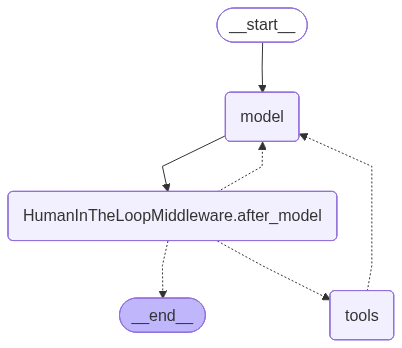

In [19]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langchain_core.tools import tool
from langchain.messages import HumanMessage

@tool
def read_email_tool(email_id: str)->str:
    """Mock Function to read an email by its ID"""
    return f"Email content for ID : {email_id}"

@tool
def send_email_tool(recipient: str, subject: str, body: str)->str:
    """Mock Function to send an email"""
    return f"Email sent to {recipient} with subject: {subject}"

agent = create_agent(
    model = "groq:openai/gpt-oss-120b",
    tools = [read_email_tool, send_email_tool],
    checkpointer = InMemorySaver(),
    middleware = [
        HumanInTheLoopMiddleware(
            interrupt_on = {
                "send_email_tool" : {
                    "allowed_decisions" : ["approve", "edit", "reject"]
                },
                "read_email_tool" : False,
            }
        )
    ]
)

agent

In [20]:
config_edit = {"configurable" : {"thread_id" : "test_edit1"}}

# Step 1 : Request (using wrong info)
result = agent.invoke(
    {"messages" : [HumanMessage(content="Send email to wrongmail@gmail.com with subject 'Test' and body 'Hello, How are you?")]},
    config = config_edit
)

In [21]:
result

{'messages': [HumanMessage(content="Send email to wrongmail@gmail.com with subject 'Test' and body 'Hello, How are you?", additional_kwargs={}, response_metadata={}, id='2ee9be90-a776-4e69-9e83-440c23245c7c'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to send an email using the send_email_tool. Use the function.', 'tool_calls': [{'id': 'fc_8b5aa59c-dece-4ccb-9c70-a3a622e7a16f', 'function': {'arguments': '{"body":"Hello, How are you?","recipient":"wrongmail@gmail.com","subject":"Test"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 177, 'total_tokens': 243, 'completion_time': 0.140058381, 'completion_tokens_details': {'reasoning_tokens': 17}, 'prompt_time': 0.007365967, 'prompt_tokens_details': None, 'queue_time': 0.050704652, 'total_time': 0.147424348}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_626f3fc5e0', 'service_tier': 'on_demand', 'finish_reason': 

In [22]:
from langgraph.types import Command

# Step 2 : Edit and Approve
if "__interrupt__" in result:
    print("Paused, Waiting Approval!")

    result = agent.invoke(
        Command(
            resume = {
                "decisions" : [
                    {
                        "type" : "edit",
                        "edited_action" : {
                            "name" : "send_email_tool", # Tool Name
                            "args" : {                  # Edited Arguments
                                "recipient" : "correct@gmail.com",
                                "subject" : "Corrected Subject",
                                "body" : "This is the edited body by human"
                            }
                        }
                    }
                ]
            }
        ),
        config = config_edit
    )

    # print(f"Result : {result['messages'][-1].content}")

Paused, Waiting Approval!


In [23]:
result

{'messages': [HumanMessage(content="Send email to wrongmail@gmail.com with subject 'Test' and body 'Hello, How are you?", additional_kwargs={}, response_metadata={}, id='2ee9be90-a776-4e69-9e83-440c23245c7c'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to send an email using the send_email_tool. Use the function.', 'tool_calls': [{'id': 'fc_8b5aa59c-dece-4ccb-9c70-a3a622e7a16f', 'function': {'arguments': '{"body":"Hello, How are you?","recipient":"wrongmail@gmail.com","subject":"Test"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 177, 'total_tokens': 243, 'completion_time': 0.140058381, 'completion_tokens_details': {'reasoning_tokens': 17}, 'prompt_time': 0.007365967, 'prompt_tokens_details': None, 'queue_time': 0.050704652, 'total_time': 0.147424348}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_626f3fc5e0', 'service_tier': 'on_demand', 'finish_reason': 